# Imputación de Datos de Indicadores con KMeans

En este notebook se utiliza clustering KMeans para imputar valores faltantes en el dataset de indicadores municipales. El número óptimo de clusters (K) se selecciona utilizando el coeficiente de silueta.

## Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

from ind import print_munprofile

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Lectura del dataset

In [2]:
df = pd.read_csv('../data/processed/indicators_municipal.csv')
print(f"Shape del dataset: {df.shape}")
df.head()

Shape del dataset: (570, 13)


,cve_mun,municipio,grad_margi,grad_rez_social,conectividad,servicios_basicos,elementos_salud,educacion,desigualdad,dependencia_economica,calidad_vivienda,seguridad_alimentaria,seguridad_social
0,20001,Abejones,Alto,Medio,Bajo,Bajo,Alto,Alto,Medio,Alto,Medio,Bajo,Alto
1,20002,Acatlán de Pérez Figueroa,Medio,Bajo,Medio,Bajo,Bajo,Medio,Medio,Medio,Medio,Medio,Medio
2,20003,Asunción Cacalotepec,Alto,Muy alto,Muy bajo,Muy bajo,Medio,Medio,Medio,Alto,Medio,Alto,Medio
3,20004,Asunción Cuyotepeji,Medio,Bajo,Bajo,Bajo,NaN,Medio,Medio,Alto,Medio,Medio,Medio
4,20005,Asunción Ixtaltepec,Bajo,Bajo,Medio,Bajo,Medio,Medio,Medio,Medio,Medio,Bajo,Medio


## Identificar columnas con datos faltantes

In [3]:
to_keep = ["elementos_salud", "desigualdad", "dependencia_economica"]
all_cols_missing = []

# Mostrar conteo de valores faltantes por columna
print("Columnas con valores faltantes:")
print("=" * 50)
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df)) * 100
        print(f"{col}: {missing_count} ({missing_pct:.2f}%)")
        all_cols_missing.append(col)

# Eliminar columnas con valores faltantes excepto las que queremos conservar
to_remove = [col for col in all_cols_missing if col not in to_keep]
print(f"\nEliminando ({len(to_remove)}) columnas con valores faltantes")
df_cleaned = df.drop(columns=to_remove)
print(f"Nuevas dimensiones: {df_cleaned.shape}")

Columnas con valores faltantes:
elementos_salud: 167 (29.30%)
desigualdad: 4 (0.70%)
dependencia_economica: 10 (1.75%)

Eliminando (0) columnas con valores faltantes
Nuevas dimensiones: (570, 13)


## Mostrar perfil antes de la imputación

In [4]:
muns = ["Matías Romero Avendaño", "Magdalena Mixtepec", "Asunción Cuyotepeji"]

In [5]:
for municipality_name in muns:
    print(f"\n\nPerfil del municipio antes de la imputación de datos:")
    print_munprofile(df_cleaned, municipality_name)



Perfil del municipio antes de la imputación de datos:

================= PERFIL DEL MUNICIPIO: MATÍAS ROMERO AVENDAÑO =================

RESUMEN DEL PERFIL:
  • Marginación: Medio
  • Rezago social: Bajo
  • Conectividad: Medio
  • Servicios básicos: Bajo
  • Elementos de salud: Medio
  • Educación: Medio
  • Desigualdad: nan
  • Dependencia económica: Medio
  • Calidad de vivienda: Medio
  • Grado de acceso a alimentos: Bajo
  • Grado de acceso a servicios de salud: Bajo


Perfil del municipio antes de la imputación de datos:

=================== PERFIL DEL MUNICIPIO: MAGDALENA MIXTEPEC ===================

RESUMEN DEL PERFIL:
  • Marginación: Alto
  • Rezago social: Muy alto
  • Conectividad: Bajo
  • Servicios básicos: Muy bajo
  • Elementos de salud: Medio
  • Educación: Medio
  • Desigualdad: Medio
  • Dependencia económica: nan
  • Calidad de vivienda: Medio
  • Grado de acceso a alimentos: Medio
  • Grado de acceso a servicios de salud: Medio


Perfil del municipio antes de la

## Separar metadatos

In [6]:
metadata_cols = ["cve_mun", "municipio"]
metadata = df_cleaned[metadata_cols].copy()
df_features = df_cleaned.drop(columns=metadata_cols)

print(f"Columnas de características: {df_features.shape[1]}")
print(f"Columnas a imputar: {to_keep}")

Columnas de características: 11
Columnas a imputar: ['elementos_salud', 'desigualdad', 'dependencia_economica']


## Ejemplos de valores faltantes

In [7]:
# Para cada columna en to_keep, mostrar las primeras 3 filas con valores faltantes
to_show = []
for col in to_keep:
    missing_rows = df_features[df_features[col].isnull()].head(3)
    if not missing_rows.empty:
        print(f"\nPrimeras 3 instancias con valores vacíos en '{col}':")
        print("=" * 50)
        for index in missing_rows.index:
            municipio = metadata.loc[index, 'municipio']
            print(f"  Municipio: {municipio}")
        
        to_show.append({
            "column": col,
            "rows": missing_rows.index.tolist()
        })


Primeras 3 instancias con valores vacíos en 'elementos_salud':
  Municipio: Asunción Cuyotepeji
  Municipio: Calihualá
  Municipio: Constancia del Rosario

Primeras 3 instancias con valores vacíos en 'desigualdad':
  Municipio: Matías Romero Avendaño
  Municipio: San Francisco Chindúa
  Municipio: Santa María Chimalapa

Primeras 3 instancias con valores vacíos en 'dependencia_economica':
  Municipio: Magdalena Mixtepec
  Municipio: San Andrés Tepetlapa
  Municipio: San Francisco Logueche


## Preparación para clustering

Para poder aplicar KMeans, primero necesitamos:
1. Imputar temporalmente los valores faltantes con la media (para poder calcular clusters)
2. Estandarizar los datos
3. Encontrar el número óptimo de clusters usando el coeficiente de silueta

In [8]:
# Paso 1: Separar columnas numéricas y no numéricas
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df_features.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas no numéricas: {len(non_numeric_cols)}")
if non_numeric_cols:
    print(f"Columnas no numéricas encontradas: {non_numeric_cols[:5]}...")  # Mostrar solo las primeras 5

# Trabajar solo con columnas numéricas
df_numeric = df_features[numeric_cols].copy()

# También obtener columnas categóricas para procesarlas
categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns.tolist()
df_categorical = df_features[categorical_cols].copy() if categorical_cols else pd.DataFrame()

print(f"Columnas categóricas: {len(categorical_cols)}")
print(f"\nDatos numéricos: {df_numeric.shape}")
if not df_categorical.empty:
    print(f"Datos categóricos: {df_categorical.shape}")

Columnas numéricas: 0
Columnas no numéricas: 11
Columnas no numéricas encontradas: ['grad_margi', 'grad_rez_social', 'conectividad', 'servicios_basicos', 'elementos_salud']...
Columnas categóricas: 11

Datos numéricos: (570, 0)
Datos categóricos: (570, 11)


## Codificación de variables categóricas

Las columnas del dataset de indicadores contienen valores categóricos (Muy alto, Alto, Medio, Bajo, Muy bajo) que necesitan ser convertidos a valores numéricos para el clustering.

In [9]:
# Diccionario de etiquetas para codificación
labels = {1: "Muy alto", 2: "Alto", 3: "Medio", 4: "Bajo", 5: "Muy bajo"}
labels_reverse = {v: k for k, v in labels.items()}

# Combinar datos numéricos y categóricos
if not df_categorical.empty:
    # Codificar las columnas categóricas
    df_categorical_encoded = df_categorical.copy()
    for col in df_categorical_encoded.columns:
        df_categorical_encoded[col] = df_categorical_encoded[col].map(labels_reverse).astype(float)
    
    # Combinar con datos numéricos
    df_all_numeric = pd.concat([df_numeric, df_categorical_encoded], axis=1)
    print("Columnas categóricas codificadas y combinadas con numéricas")
else:
    df_all_numeric = df_numeric.copy()
    print("No se encontraron columnas categóricas")

print(f"\nDataset completamente numérico: {df_all_numeric.shape}")
df_all_numeric.head()

Columnas categóricas codificadas y combinadas con numéricas

Dataset completamente numérico: (570, 11)


,grad_margi,grad_rez_social,conectividad,servicios_basicos,elementos_salud,educacion,desigualdad,dependencia_economica,calidad_vivienda,seguridad_alimentaria,seguridad_social
0,2.0,3.0,4.0,4.0,2.0,2.0,3.0,2.0,3.0,4.0,2.0
1,3.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0
2,2.0,1.0,5.0,5.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0
3,3.0,4.0,4.0,4.0,NaN,3.0,3.0,2.0,3.0,3.0,3.0
4,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0


In [10]:
# Paso 2: Imputación temporal con la media para poder aplicar KMeans
temp_imputer = SimpleImputer(strategy='mean')
df_temp_imputed = pd.DataFrame(
    temp_imputer.fit_transform(df_all_numeric),
    columns=df_all_numeric.columns,
    index=df_all_numeric.index
)

# Paso 3: Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_temp_imputed)

print(f"\nDatos preparados para clustering: {df_scaled.shape}")


Datos preparados para clustering: (570, 11)


## Búsqueda del K óptimo usando Coeficiente de Silueta

El coeficiente de silueta mide qué tan similar es un objeto a su propio cluster comparado con otros clusters. El rango va de -1 a 1, donde:
- Valores cercanos a 1 indican que el objeto está bien agrupado
- Valores cercanos a 0 indican que el objeto está en el borde entre dos clusters
- Valores negativos indican que el objeto puede haber sido asignado al cluster incorrecto

In [11]:
# Probar diferentes valores de K
k_range = range(2, 11)  # Probar de 2 a 10 clusters
silhouette_scores = []
inertias = []

print("Calculando coeficientes de silueta...")
print("=" * 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    # Calcular coeficiente de silueta
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    
    print(f"K={k}: Coeficiente de silueta = {silhouette_avg:.4f}")

# Encontrar el K óptimo
optimal_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print("\n" + "=" * 50)
print(f"K óptimo: {optimal_k} (Coeficiente de silueta: {best_score:.4f})")
print("=" * 50)

Calculando coeficientes de silueta...


K=2: Coeficiente de silueta = 0.2207
K=3: Coeficiente de silueta = 0.1419
K=4: Coeficiente de silueta = 0.1603
K=5: Coeficiente de silueta = 0.1661
K=4: Coeficiente de silueta = 0.1603
K=5: Coeficiente de silueta = 0.1661
K=6: Coeficiente de silueta = 0.1471
K=7: Coeficiente de silueta = 0.1503
K=8: Coeficiente de silueta = 0.1568
K=6: Coeficiente de silueta = 0.1471
K=7: Coeficiente de silueta = 0.1503
K=8: Coeficiente de silueta = 0.1568
K=9: Coeficiente de silueta = 0.1566
K=10: Coeficiente de silueta = 0.1602

K óptimo: 2 (Coeficiente de silueta: 0.2207)
K=9: Coeficiente de silueta = 0.1566
K=10: Coeficiente de silueta = 0.1602

K óptimo: 2 (Coeficiente de silueta: 0.2207)


## Visualización de resultados

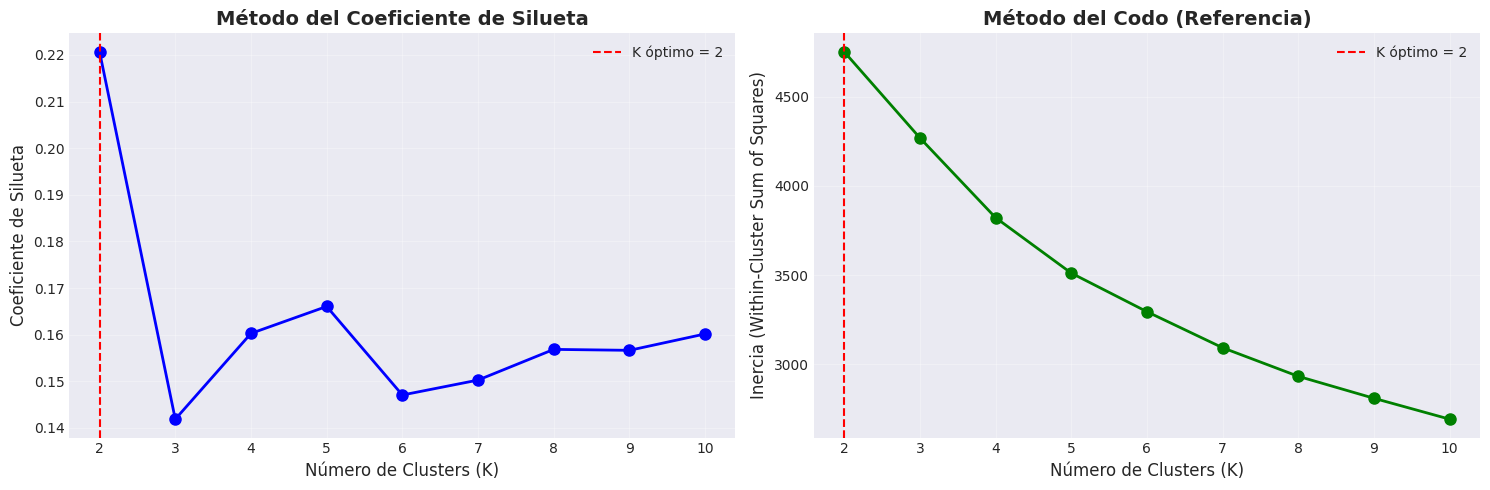


El K óptimo (2) maximiza el coeficiente de silueta.


In [12]:
# Crear gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Coeficiente de Silueta
ax1.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='r', linestyle='--', label=f'K óptimo = {optimal_k}')
ax1.set_xlabel('Número de Clusters (K)', fontsize=12)
ax1.set_ylabel('Coeficiente de Silueta', fontsize=12)
ax1.set_title('Método del Coeficiente de Silueta', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xticks(k_range)

# Gráfica 2: Método del Codo (Elbow Method) - como referencia
ax2.plot(k_range, inertias, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k, color='r', linestyle='--', label=f'K óptimo = {optimal_k}')
ax2.set_xlabel('Número de Clusters (K)', fontsize=12)
ax2.set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
ax2.set_title('Método del Codo (Referencia)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(k_range)

plt.tight_layout()
plt.show()

print(f"\nEl K óptimo ({optimal_k}) maximiza el coeficiente de silueta.")

## Aplicar KMeans con K óptimo

In [13]:
# Entrenar KMeans con el K óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Agregar las etiquetas de cluster al dataframe
df_features['cluster'] = cluster_labels

print(f"Clustering completado con K={optimal_k}")
print("\nDistribución de clusters:")
print(df_features['cluster'].value_counts().sort_index())

Clustering completado con K=2

Distribución de clusters:
cluster
0    358
1    212
Name: count, dtype: int64


## Imputación usando la media del cluster

Para cada valor faltante, lo imputamos con la media de su cluster correspondiente.

In [14]:
# Crear una copia del dataframe numérico original para imputación
df_imputed = df_all_numeric.copy()
df_imputed['cluster'] = cluster_labels

# Para cada columna con valores faltantes
for col in to_keep:
    missing_mask = df_imputed[col].isnull()
    
    if missing_mask.any():
        print(f"\nImputando '{col}'...")
        
        # Para cada cluster
        for cluster_id in range(optimal_k):
            # Obtener la máscara de este cluster
            cluster_mask = df_imputed['cluster'] == cluster_id
            
            # Combinar: valores faltantes Y en este cluster
            impute_mask = missing_mask & cluster_mask
            
            if impute_mask.any():
                # Calcular la media del cluster (sin incluir NaN)
                cluster_mean = df_imputed.loc[cluster_mask, col].mean()
                
                # Si todos los valores del cluster son NaN, usar la media global
                if pd.isna(cluster_mean):
                    cluster_mean = df_imputed[col].mean()
                
                # Imputar
                df_imputed.loc[impute_mask, col] = cluster_mean
                
                n_imputed = impute_mask.sum()
                print(f"  Cluster {cluster_id}: {n_imputed} valores imputados con media = {cluster_mean:.4f}")

# Redondear todas las columnas a entero
for col in df_imputed.columns:
    if col != 'cluster':  # No redondear la columna de cluster
        df_imputed[col] = df_imputed[col].round().astype(int)

print("\n" + "=" * 50)
print("Imputación completada exitosamente")
print("=" * 50)


Imputando 'elementos_salud'...
  Cluster 0: 113 valores imputados con media = 3.3265
  Cluster 1: 54 valores imputados con media = 2.6582

Imputando 'desigualdad'...
  Cluster 0: 2 valores imputados con media = 2.8792
  Cluster 1: 2 valores imputados con media = 2.7333

Imputando 'dependencia_economica'...
  Cluster 0: 10 valores imputados con media = 2.3477

Imputación completada exitosamente


## Verificar que no quedan valores faltantes

In [15]:
print("Valores faltantes después de la imputación:")
print("=" * 50)
for col in to_keep:
    missing_count = df_imputed[col].isnull().sum()
    print(f"{col}: {missing_count} valores faltantes")

if df_imputed[to_keep].isnull().sum().sum() == 0:
    print("\n✓ Todos los valores han sido imputados correctamente")
else:
    print("\n✗ Aún quedan valores faltantes")

Valores faltantes después de la imputación:
elementos_salud: 0 valores faltantes
desigualdad: 0 valores faltantes
dependencia_economica: 0 valores faltantes

✓ Todos los valores han sido imputados correctamente


Agregar columnas de metadatos nuevamente

In [16]:
# Concatenar metadata y df_imputed
# Remover la columna 'cluster' antes de concatenar
df_imputed_without_cluster = df_imputed.drop(columns=['cluster'])

df_final = pd.concat([metadata, df_imputed_without_cluster], axis=1)
print(f"\nDimensiones del dataset final: {df_final.shape}")
df_final.head()


Dimensiones del dataset final: (570, 13)


,cve_mun,municipio,grad_margi,grad_rez_social,conectividad,servicios_basicos,elementos_salud,educacion,desigualdad,dependencia_economica,calidad_vivienda,seguridad_alimentaria,seguridad_social
0,20001,Abejones,2,3,4,4,2,2,3,2,3,4,2
1,20002,Acatlán de Pérez Figueroa,3,4,3,4,4,3,3,3,3,3,3
2,20003,Asunción Cacalotepec,2,1,5,5,3,3,3,2,3,2,3
3,20004,Asunción Cuyotepeji,3,4,4,4,3,3,3,2,3,3,3
4,20005,Asunción Ixtaltepec,4,4,3,4,3,3,3,3,3,4,3


## Decodificar variables categóricas

Convertir los valores numéricos de vuelta a las etiquetas categóricas originales.

In [17]:
# Decodificar las columnas categóricas de vuelta a sus etiquetas originales
if categorical_cols:
    for col in categorical_cols:
        if col in df_final.columns:
            df_final[col] = df_final[col].map(labels).astype('category')
    print(f"Columnas categóricas decodificadas: {len(categorical_cols)}")
else:
    print("No hay columnas categóricas para decodificar")

print("\nPrimeras filas del dataset final:")
df_final.head()

Columnas categóricas decodificadas: 11

Primeras filas del dataset final:


,cve_mun,municipio,grad_margi,grad_rez_social,conectividad,servicios_basicos,elementos_salud,educacion,desigualdad,dependencia_economica,calidad_vivienda,seguridad_alimentaria,seguridad_social
0,20001,Abejones,Alto,Medio,Bajo,Bajo,Alto,Alto,Medio,Alto,Medio,Bajo,Alto
1,20002,Acatlán de Pérez Figueroa,Medio,Bajo,Medio,Bajo,Bajo,Medio,Medio,Medio,Medio,Medio,Medio
2,20003,Asunción Cacalotepec,Alto,Muy alto,Muy bajo,Muy bajo,Medio,Medio,Medio,Alto,Medio,Alto,Medio
3,20004,Asunción Cuyotepeji,Medio,Bajo,Bajo,Bajo,Medio,Medio,Medio,Alto,Medio,Medio,Medio
4,20005,Asunción Ixtaltepec,Bajo,Bajo,Medio,Bajo,Medio,Medio,Medio,Medio,Medio,Bajo,Medio


## Mostrar los valores imputados

In [18]:
print("Valores imputados para las instancias previamente identificadas:")
print("=" * 70)

for item in to_show:
    col = item["column"]
    rows = item["rows"]
    print(f"\nValores imputados para '{col}':")
    print(df_final.loc[rows, ["municipio", col]])

Valores imputados para las instancias previamente identificadas:

Valores imputados para 'elementos_salud':
                 municipio elementos_salud
3      Asunción Cuyotepeji           Medio
10               Calihualá           Medio
19  Constancia del Rosario           Medio

Valores imputados para 'desigualdad':
                  municipio desigualdad
56   Matías Romero Avendaño       Medio
139   San Francisco Chindúa       Medio
406   Santa María Chimalapa       Medio

Valores imputados para 'dependencia_economica':
                  municipio dependencia_economica
47       Magdalena Mixtepec                  Alto
98     San Andrés Tepetlapa                  Alto
145  San Francisco Logueche                  Alto


## Análisis de resultados por cluster

In [19]:
# Estadísticas descriptivas por cluster para las columnas imputadas
print("Estadísticas por cluster para las columnas imputadas:")
print("=" * 70)

for col in to_keep:
    print(f"\n{col.upper()}:")
    print("-" * 70)
    cluster_stats = df_imputed.groupby('cluster')[col].agg(['count', 'mean', 'std', 'min', 'max'])
    print(cluster_stats)

Estadísticas por cluster para las columnas imputadas:

ELEMENTOS_SALUD:
----------------------------------------------------------------------
         count      mean       std  min  max
cluster                                     
0          358  3.223464  0.823538    2    5
1          212  2.745283  0.689272    2    5

DESIGUALDAD:
----------------------------------------------------------------------
         count      mean       std  min  max
cluster                                     
0          358  2.879888  0.325547    2    3
1          212  2.735849  0.441924    2    3

DEPENDENCIA_ECONOMICA:
----------------------------------------------------------------------
         count      mean       std  min  max
cluster                                     
0          358  2.337989  0.529530    1    3
1          212  2.481132  0.500826    2    3


## Visualización de clusters (PCA para 2D)

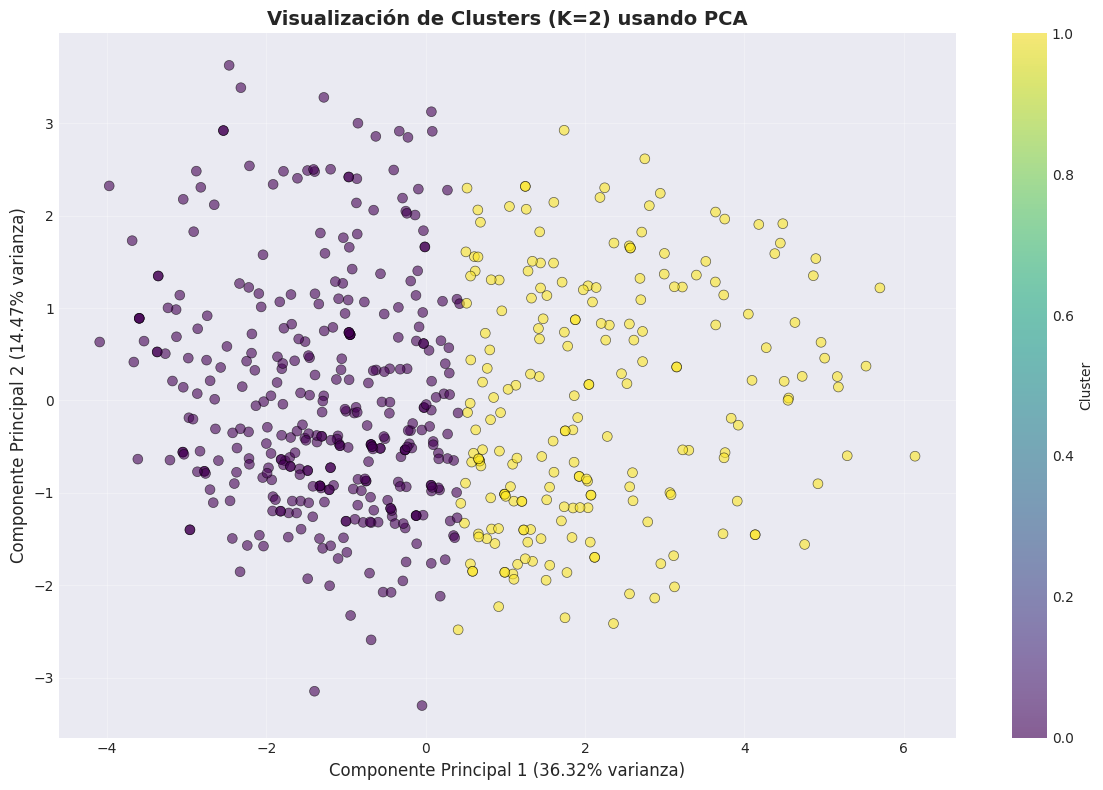


Varianza explicada total: 50.78%


In [20]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Crear visualización
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     alpha=0.6, 
                     edgecolors='black',
                     linewidth=0.5,
                     s=50)

plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} varianza)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} varianza)', fontsize=12)
plt.title(f'Visualización de Clusters (K={optimal_k}) usando PCA', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nVarianza explicada total: {sum(pca.explained_variance_ratio_):.2%}")

## Mostrar perfil después de la imputación

In [21]:
# show profile after imputation
for municipality_name in muns:
    print(f"\n\nPerfil del municipio después de la imputación de datos:")
    print_munprofile(df_final, municipality_name)



Perfil del municipio después de la imputación de datos:

================= PERFIL DEL MUNICIPIO: MATÍAS ROMERO AVENDAÑO =================

RESUMEN DEL PERFIL:
  • Marginación: Medio
  • Rezago social: Bajo
  • Conectividad: Medio
  • Servicios básicos: Bajo
  • Elementos de salud: Medio
  • Educación: Medio
  • Desigualdad: Medio
  • Dependencia económica: Medio
  • Calidad de vivienda: Medio
  • Grado de acceso a alimentos: Bajo
  • Grado de acceso a servicios de salud: Bajo


Perfil del municipio después de la imputación de datos:

=================== PERFIL DEL MUNICIPIO: MAGDALENA MIXTEPEC ===================

RESUMEN DEL PERFIL:
  • Marginación: Alto
  • Rezago social: Muy alto
  • Conectividad: Bajo
  • Servicios básicos: Muy bajo
  • Elementos de salud: Medio
  • Educación: Medio
  • Desigualdad: Medio
  • Dependencia económica: Alto
  • Calidad de vivienda: Medio
  • Grado de acceso a alimentos: Medio
  • Grado de acceso a servicios de salud: Medio


Perfil del municipio desp